In [36]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from osgeo import gdal
from osgeo.osr import SpatialReference, CoordinateTransformation
from sklearn.linear_model import TheilSenRegressor
import importlib
# TODO: set up better environment so module edits are automatically reloaded
import UtilityFunctions as util
importlib.reload(util)

<module 'UtilityFunctions' from '/Users/philt/Desktop/CS 4860/forest_fire_regrowth_analysis/UtilityFunctions.py'>

(1200, 1200)
-0.3


AttributeError: module 'matplotlib.pyplot' has no attribute 'figsize'

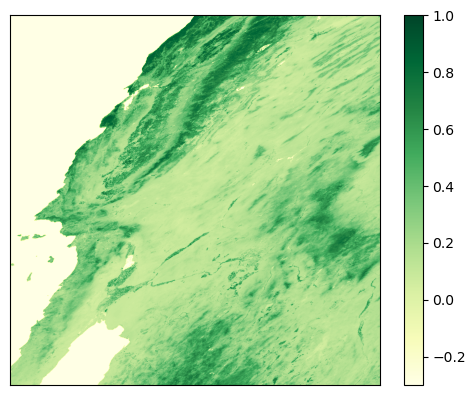

In [38]:
# example on how to import NDVI data and convert to scale
ndvi_2021215102558 = util.get_ndvi_band_pixels('./MOD13A3_08_2012-07_2013/MOD13A3.A2012214.h08v05.061.2021215102558.hdf')
print(ndvi_2021215102558.shape)
print(ndvi_2021215102558[0][0])
# plot the full granule area
plt.xticks([])
plt.yticks([])
plt.imshow(ndvi_2021215102558, cmap='YlGn')
plt.colorbar()
plt.show()

In [24]:
# trying to use gdal libraries to get relative spatial area

hdf_file = './MOD13A3_08_2012-07_2013/MOD13A3.A2012214.h08v05.061.2021215102558.hdf'

# Open the MOD13A3 hdf file, use full file path
raw_data = gdal.Open(hdf_file, gdal.GA_ReadOnly)
subdataset = gdal.Open(raw_data.GetSubDatasets()[0][0], gdal.GA_ReadOnly)
geotransform = subdataset.GetGeoTransform() # captures origin and pixel size
projection = subdataset.GetProjection()
source = SpatialReference()
source.ImportFromWkt(projection)
dest = SpatialReference()
# how to set projection method? - ours is sinusoidal
# print(dest.ImportFromEPSG(Sinusoidal))
transform = CoordinateTransformation(source, dest)
x, y = gdal.ApplyGeoTransform(geotransform, 12001, 1)
x
# print(transform.TransformPoint(x, y))
# band = subdataset.GetRasterBand(1)
# data = band.ReadAsArray()
# plt.figure(figsize=(10, 10))
# plt.imshow(data)
# plt.colorbar()

# See this https://gdal.org/tutorials/geotransforms_tut.html
#  how to we get this to work, GPS coordinates are known, relative pixel coordinate space is not
# X_geo = GT(0) + X_pixel * GT(1) + Y_line * GT(2)

ERROR 1: PROJ: proj_create: unrecognized format / unknown name
ERROR 1: Cannot instantiate target_crs
ERROR 6: Cannot find coordinate operations from `PROJCRS["unnamed",BASEGEOGCRS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",ELLIPSOID["Custom spheroid",6371007.181,0,LENGTHUNIT["metre",1,ID["EPSG",9001]]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]]],CONVERSION["unnamed",METHOD["Sinusoidal"],PARAMETER["Longitude of natural origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["False easting",0,LENGTHUNIT["Meter",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["Meter",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["easting",east,ORDER[1],LENGTHUNIT["Meter",1]],AXIS["northing",north,ORDER[2],LENGTHUNIT["Meter",1]]]' to `'


926.6254360694438

In [10]:
# Right now function just returns true NDVI for spacial rectangle
# Function returns dataframe containing NDVI, mean, std, skew, and x y indices of each pixel from hdf file
def pre_process_hdf(hdf_file):
  # Open the MOD13A3 hdf file, use full file path
  raw_data = gdal.Open(hdf_file, gdal.GA_ReadOnly)
  subdatasets = raw_data.GetSubDatasets()

  # select the subdataset containing NDVI data
  ndvi_subdataset = None
  for subdataset in subdatasets:
      if "NDVI" in subdataset[0]:
          ndvi_subdataset = subdataset[0]
          break
  # open ndvi subset and subset out the bounding affected area rectangle
  ndvi_raw_dataset = gdal.Open(ndvi_subdataset, gdal.GA_ReadOnly)

  # get metadata variables
  ndvi_metadata = ndvi_raw_dataset.GetMetadata()
  # footprint boundary GPS coordinates
  boundary_n = float(ndvi_metadata['NORTHBOUNDINGCOORDINATE'])
  boundary_s = float(ndvi_metadata['SOUTHBOUNDINGCOORDINATE'])
  boundary_e = float(ndvi_metadata['EASTBOUNDINGCOORDINATE'])
  boundary_w = float(ndvi_metadata['WESTBOUNDINGCOORDINATE'])
  # values to calculate true NDVI from raw data
  ndvi_fill_value = int(ndvi_metadata['_FillValue'])
  nvdi_scale_factor = int(ndvi_metadata['scale_factor'])

  # convert to np array
  ndvi_raw_data = ndvi_raw_dataset.ReadAsArray()

  # NDVI from raw data, ndvi = (ndvi_raw - ndvi_fill) / ndvi_scale
  ndvi_data = ndvi_raw_data / nvdi_scale_factor

  # close the datasets
  ndvi_dataset = None
  hdf_file = None

  # get the effected fire area from spacial GPS rectangle
  n, m = ndvi_data.shape
  spatial_n, spatial_s, spatial_e, spatial_w = (39.22, 37.66, -119.57, -120.81)
  # Transopse the spacial data from the bounding box - needs to be fixed
  row_start = int((boundary_n - spatial_n) / (boundary_n - boundary_s) * n)
  row_end = int((boundary_n - spatial_s) / (boundary_n - boundary_s) * n)
  col_start = int((spatial_w - boundary_w) / (boundary_e - boundary_w) * m)
  col_end = int((spatial_e - boundary_w) / (boundary_e - boundary_w) * m)
  # Extract the smaller area of the NDVI array
  spacial_ndvi_data = ndvi_data[row_start:row_end, col_start:col_end]

  # ndvi_mean = np.mean(spacial_ndvi_data)
  # ndvi_std = np.std(spacial_ndvi_data)
  # ndvi_skew = sp.stats.skew(spacial_ndvi_data)

  # get x and y values from ndvi dataset
  # x, y = np.meshgrid(range(spacial_ndvi_data.shape[1]), range(spacial_ndvi_data.shape[0]))
  # convert numpy array to dataframe
  # cleaned_ndvi_dataset = np.stack([spacial_ndvi_data, np.full_like(spacial_ndvi_data,ndvi_mean), np.full_like(spacial_ndvi_data,ndvi_std), np.full_like(spacial_ndvi_data,ndvi_skew), x, y], axis=2)
  # cleaned_ndvi_reshaped = cleaned_ndvi_dataset.reshape(-1, 6)

  # Calculate RTI using Theil-Sen's estimator
  # Call function to calculate RTI
  # rti_data = rti(ndvi_data)

  # return ndvi_raw_data
  return spacial_ndvi_data
  # return pd.DataFrame(cleaned_ndvi_reshaped, columns=['NDVI', 'mean', 'std', 'skew', 'x', 'y'])

In [9]:
# MOD13A3_pre_fire_folder = 'test'
# for file in MOD13A3_pre_fire_folder
ndvi_processed = pre_process_hdf('./MOD13A3_08_2012-07_2013/MOD13A3.A2012214.h08v05.061.2021215102558.hdf')
ndvi_processed.shape

NameError: name 'pre_process_hdf' is not defined

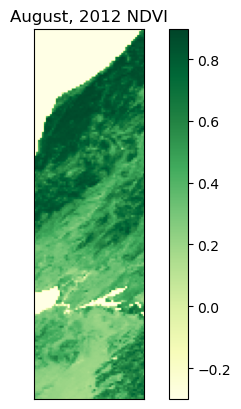

In [13]:
# plot the fire area
plt.xticks([])
plt.yticks([])
plt.imshow(ndvi_processed, cmap='YlGn')
plt.colorbar()
plt.title('August, 2012 NDVI')
plt.show()